# Choice Function

In [2]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from csrank import *
from keras.optimizers import SGD

## Learning Pareto-Optimality

We now try to solve the problem of predicting the Pareto-optimal set of points $O \subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [3]:
from csrank import ChoiceDatasetGenerator
seed = 12
n_train = 10000
n_test = 10000
n_features = 2
n_objects = 40
gen = ChoiceDatasetGenerator(dataset_type='pareto', random_state=seed,
                                n_train_instances=n_train,
                                n_test_instances=n_test,
                                n_objects=n_objects,
                                n_features=n_features)

In [4]:
X_train, Y_train, X_test, Y_test = gen.get_single_train_test_split()

Let us plot a random instances. The pareto points are marked with orange color.

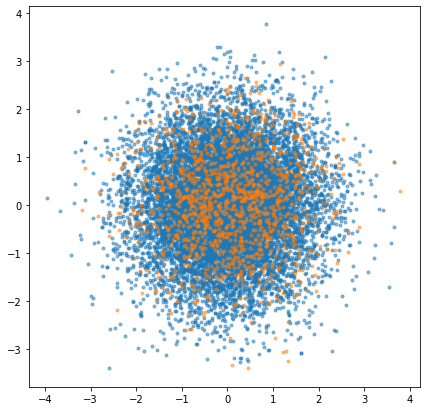

In [5]:
colors = sns.color_palette('tab10', n_colors=2)
fig, ax = plt.subplots(figsize=(7,7))
inst = np.random.choice(n_train, size=300)
rows, cols = np.where(Y_train[inst]==1)
ax.scatter(X_train[inst].reshape(-1,2)[:, 0], X_train[inst].reshape(-1,2)[:, 1], c=[colors[0]], marker='.', alpha=0.5)
ax.scatter(X_train[rows, cols][:, 0], X_train[rows, cols][:, 1], c=[colors[1]], marker='.', alpha=0.5)
plt.show()

## The RankNet network
This network learns a latent utility score for each object in the given choice set $Q = \{\vec{x}_1, \ldots , \vec{x}_n\}$
\begin{equation}
	U(\vec{x}_i) = F(\vec{x}_i, \vec{\beta}) \enspace,
\end{equation}
where the weight vector $\vec{\beta}$ is estimated using pairwise preferences generated from the choices.
For Example, the decision maker is faced with choice set $Q = \{ \vec{x_1}, \ldots ,\vec{x_5} \}$ and chooses the object $\vec{x_4}$. 
Then one can extract the following _pairwise preferences_, $\vec{x_4} \succ \vec{x_1}, \vec{x_4} \succ \vec{x_2}, \ldots$. 

In [6]:
ranknet = RankNetChoiceFunction(
    n_object_features=n_features,
    optimizer=SGD(lr=1e-4, nesterov=True, momentum=0.9))

We will run the training for only 10 epochs to get an idea of the convergence:

In [7]:
ranknet.fit(X_train, Y_train, verbose=True, epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 2430581 samples, validate on 270065 samples
Epoch 1/10
2430581/2430581 [==============================] - 17s 7us/step - loss: 0.1507 - binary_accuracy: 0.9444 - val_loss: 0.0977 - val_binary_accuracy: 0.9681
Epoch 2/10
2430581/2430581 [==============================] - 16s 7us/step - loss: 0.0882 - binary_accuracy: 0.9685 - val_loss: 0.0825 - val_binary_accuracy: 0.9711
Epoch 3/10
2430581/2430581 [==============================] - 18s 7us/step - loss: 0.0817 - binary_accuracy: 0.9703 - val_loss: 0.0782 - val_binary_accuracy: 0.9716
Epoch 4/10
2430581/2430581 [==============================] - 17s 7us/step - loss: 0.0794 - binary_accuracy: 0.9711 - val_loss: 0.0751 - val_binary_accuracy: 0.9727
Epoch 5/10
2430581/2430581 [==============================] - 17s 7us/step - loss: 0.0782 - binary_accuracy: 0.9713 - val_loss: 0.0729 - val_binary_accuracy: 0.9737
Epoch 6/10
2430581/2430581 [==============================] - 40s 16us/ste

In [8]:
scores = ranknet.predict_scores(X_test)
y_pred = ranknet.predict_for_scores(scores)

In [9]:
from csrank.metrics_np import f1_measure
f1_measure(Y_test, y_pred)

0.5941317737052706

Not converged yet, but let us visualize the scores it assigns to test instances:

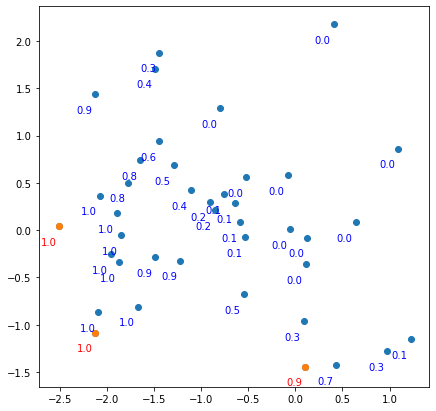

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
inst = np.random.choice(n_test)
choices = np.where(Y_test[inst]==1)[0]
ax.scatter(X_test[inst][:, 0], X_test[inst][:, 1])
ax.scatter(X_test[inst][choices, 0], X_test[inst][choices, 1])
for i in range(n_objects):
    if Y_test[inst, i]:
        color = 'r'
    else:
        color = 'b'
    ax.text(X_test[inst, i, 0]-0.2,
            X_test[inst, i, 1]-0.2,
            s='{:.1f}'.format(scores[inst][i]),
            color=color)